<a href="https://colab.research.google.com/github/spros1/DistanceJoin/blob/main/DistanceJoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###First we need to install everything needed in order to run Python & Apache Spark in Colab


In [27]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [13]:
# download spark3.2.1
!wget -q https://ftp.cc.uoc.gr/mirrors/apache/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz 

In [ ]:
# unzip it
!tar xvf spark-3.2.1-bin-hadoop2.7.tgz

In [15]:
# install findspark 
!pip install -q findspark

In [16]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

#### A test in order to check that all are ok

In [271]:
import findspark
findspark.init()                                               # make pyspark importable as a regular library
from pyspark.sql import SparkSession                           # create Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Test spark
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(5)

+-----+
|hello|
+-----+
|world|
|world|
|world|
|world|
|world|
+-----+
only showing top 5 rows



In [273]:
# the previous were just to test that spark was ok set up , we will start it again
spark.stop()

# Now lets start :
For two sets given A and B ( with values (ID,X,Y) ) : <br>
Find the pairs (a,b), where a in Α and b in Β, 
to wich it applies : d(a,b) ≤ c, where c parameter given from the user 

### First we are going to make a routine in order to produce two csv files with the number of records that the user will give


In [274]:
# imports that are going to be used for the population for our two datasets 
import random
from random import sample
import csv

In [275]:
def get_generated_points( gen_num, csv_name):
  
  x = random.sample(range(1, gen_num+1), gen_num)
  y = random.sample(range(1, gen_num+1), gen_num)

  fin_data = list(zip(x,y))
 
# generate csv
  with open(csv_name, "a") as f:
    f.truncate(0)
    coords = [map(str, tupl) for tupl in fin_data]
    writer = csv.writer(f, delimiter=',')

    for line in coords:
      writer.writerow(line)

# plot it also that 
  plt.scatter(x, y)
  plt.show()

  return fin_data

#### Now the user must give the max number of points for the two datasets

In [276]:
inpCSV_total_points = 0
try:
  inpCSV_total_points = int(input("Enter the max value for csv with inp points : "))
except ValueError:
    print("This is not a number")   

Enter the max value for csv with inp points : 10


In [277]:
trainCSV_total_points = 0
try:
  trainCSV_total_points = int(input("Enter the max value for csv with train points : "))
except ValueError:
    print("This is not a number")   

Enter the max value for csv with train points : 5


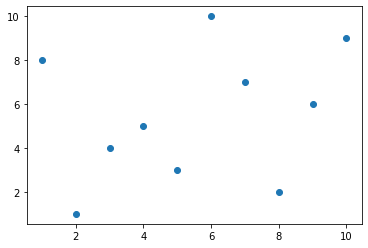

[(9, 6), (10, 9), (8, 2), (1, 8), (3, 4), (7, 7), (6, 10), (2, 1), (5, 3), (4, 5)]




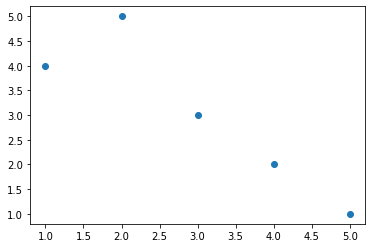

[(2, 5), (1, 4), (4, 2), (5, 1), (3, 3)]


In [278]:
# create the input dataset
inpPoints = get_generated_points(inpCSV_total_points , 'InputCSV.csv')
print(inpPoints)

print('\n')

trainPoints = get_generated_points(trainCSV_total_points , 'TrainCSV.csv')
print(trainPoints)

### Read from the two csvs the data
(from the two we create or other , it is the same just change the name of input file)


In [357]:
# importing the required module
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import lit,col,concat
import os

import matplotlib.pyplot as plt
import numpy as np

In [287]:
# give the path of input and train file to read 
inpFile   = "InputCSV.csv" 
trainFile = "TrainCSV.csv"

In [289]:
spark = SparkSession.builder.appName("CSV").master("local").getOrCreate()             # Creates a session on a local master

df_inp   = spark.read.csv(inferSchema=True, path=inpFile).toDF("inpX"  ,"inpY"  )     # Reads input CSV file with no header, in a dataframe
df_train = spark.read.csv(inferSchema=True, path=trainFile).toDF("trainX","trainY")   # Reads train CSV file with no header, in a dataframe

In [295]:
print("*** Right after ingestion ***")

df_inp.show(5)
print("We have {} input records.".format(df_inp.count()))

print('\n')

df_train.show(5)
print("We have {} train records.".format(df_train.count()))

*** Right after ingestion ***
+----+----+
|inpX|inpY|
+----+----+
|   9|   6|
|  10|   9|
|   8|   2|
|   1|   8|
|   3|   4|
+----+----+
only showing top 5 rows

We have 10 input records.


+------+------+
|trainX|trainY|
+------+------+
|     2|     5|
|     1|     4|
|     4|     2|
|     5|     1|
|     3|     3|
+------+------+

We have 5 train records.


In [296]:
# Print the schema to standard output (stdout) by using printSchema().
df_inp.printSchema()
df_train.printSchema()

root
 |-- inpX: integer (nullable = true)
 |-- inpY: integer (nullable = true)

root
 |-- trainX: integer (nullable = true)
 |-- trainY: integer (nullable = true)



### Plot the points ( inp -> o , train -> x )

In [299]:
# Add a new column: COORD which consists of: (X,Y)
df_inp = df_inp.withColumn("COORD_inp", concat(lit("("), col("inpX"), lit(","), col("inpY"), lit(")")))

print("*** Input Dataframe Transformed")
df_inp.show(5)

*** Input Dataframe Transformed
+----+----+------+---------+
|inpX|inpY| COORD|COORD_inp|
+----+----+------+---------+
|   9|   6| (9,6)|    (9,6)|
|  10|   9|(10,9)|   (10,9)|
|   8|   2| (8,2)|    (8,2)|
|   1|   8| (1,8)|    (1,8)|
|   3|   4| (3,4)|    (3,4)|
+----+----+------+---------+
only showing top 5 rows



In [301]:
# Add a new column: COORD which consists of: (X,Y)
df_train = df_train.withColumn("COORD_train", concat(lit("("), col("trainX"), lit(","), col("trainY"), lit(")")))



*** Input Dataframe Transformed
+------+------+-----------+
|trainX|trainY|COORD_train|
+------+------+-----------+
|     2|     5|      (2,5)|
|     1|     4|      (1,4)|
|     4|     2|      (4,2)|
|     5|     1|      (5,1)|
|     3|     3|      (3,3)|
+------+------+-----------+



In [307]:
print("*** Input and train Dataframes Transformed :")
df_inp.show(5)
df_train.show(5)

*** Input and train Dataframes Transformed :
+----+----+---------+
|inpX|inpY|COORD_inp|
+----+----+---------+
|   9|   6|    (9,6)|
|  10|   9|   (10,9)|
|   8|   2|    (8,2)|
|   1|   8|    (1,8)|
|   3|   4|    (3,4)|
+----+----+---------+
only showing top 5 rows

+------+------+-----------+
|trainX|trainY|COORD_train|
+------+------+-----------+
|     2|     5|      (2,5)|
|     1|     4|      (1,4)|
|     4|     2|      (4,2)|
|     5|     1|      (5,1)|
|     3|     3|      (3,3)|
+------+------+-----------+



In [323]:
# first find the max values from each dataframe in order to find the quadrants
maxX_inp = df_inp.agg({"inpX":"max"}).first()[0]     
maxX_trn = df_train.agg({"trainX":"max"}).first()[0]  

maxY_inp = df_inp.agg({"inpY":"max"}).first()[0]  
maxY_trn = df_train.agg({"trainY":"max"}).first()[0]

min_quadran = (max(maxX_inp,maxX_trn))
max_quadran = (max(maxY_inp,maxY_trn))

print(min_quadran)
print(max_quadran)

10
10


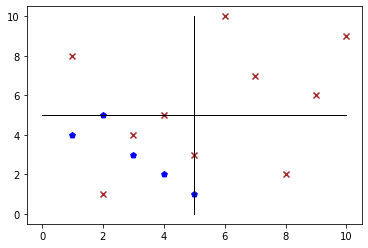

In [380]:
mx = [val.inpX for val in df_inp.select('inpX').collect()]
my = [val.inpY for val in df_inp.select('inpY').collect()]
plt.scatter(mx, my, marker='x', color = 'brown')

tx = [val.trainX for val in df_train.select('trainX').collect()]
ty = [val.trainY for val in df_train.select('trainY').collect()]
plt.scatter(tx, ty, marker='p', color = 'blue')

# Draw lines to split quadrants
plt.plot([min_quadran/2,min_quadran/2],[0,max_quadran], linewidth=1, color='black' )
plt.plot([0,min_quadran],[max_quadran/2,max_quadran/2], linewidth=1, color='black' )

plt.show()

Get the value for distance range from user

In [325]:
range_val = 0
try:
  range_val = int(input("Enter your value for range : "))
except ValueError:
    print("This is not a number")    

Enter your value for range : 2


#### Create a function that calculates the distance between two points

In [326]:
# Function to calculate distance between points using Pythagoras' theorem
import math
def distance(i1 , t1 , i2 , t2):
 
    return math.sqrt(math.pow(i2 - i1, 2) + math.pow(t2 - t1, 2) * 1.0)

In [419]:
# function to call in order to calculate the points of train that are in range of points of input

def check_in_range(i, t, r):

  for a in range(i.count()) :
   for b in range(t.count()) :
    print( '(' , i.collect()[a][0] , i.collect()[a][1] , ')', '-', '(' , t.collect()[b][0] , t.collect()[b][1], ')')
    dist = distance(i.collect()[a][1] , i.collect()[a][0] , t.collect()[b][1] , t.collect()[b][0])

    if dist <= range_val :
      print("Points in range :", dist, "<=", r)
    else : 
      print("Points out of range :", dist, ">", r)
    
    print("----------------------")

### Now call the functions in order to get the requested results

In [420]:
list_with_range_flag = []
check_in_range(df_inp, df_train, range_val)

( 9 6 ) - ( 2 5 )
Points out of range : 7.0710678118654755 > 2
----------------------
( 9 6 ) - ( 1 4 )
Points out of range : 8.246211251235321 > 2
----------------------
( 9 6 ) - ( 4 2 )
Points out of range : 6.4031242374328485 > 2
----------------------
( 9 6 ) - ( 5 1 )
Points out of range : 6.4031242374328485 > 2
----------------------
( 9 6 ) - ( 3 3 )
Points out of range : 6.708203932499369 > 2
----------------------
( 10 9 ) - ( 2 5 )
Points out of range : 8.94427190999916 > 2
----------------------
( 10 9 ) - ( 1 4 )
Points out of range : 10.295630140987 > 2
----------------------
( 10 9 ) - ( 4 2 )
Points out of range : 9.219544457292887 > 2
----------------------
( 10 9 ) - ( 5 1 )
Points out of range : 9.433981132056603 > 2
----------------------
( 10 9 ) - ( 3 3 )
Points out of range : 9.219544457292887 > 2
----------------------
( 8 2 ) - ( 2 5 )
Points out of range : 6.708203932499369 > 2
----------------------
( 8 2 ) - ( 1 4 )
Points out of range : 7.280109889280518 > 